# Final task:  
# Dimensionality reduction via principal component analysis

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from IPython.display import HTML
import random
import copy
import numpy as np
import scipy as scy

from tqdm.notebook import trange, tqdm
import time 
from scipy.stats import maxwell

#used for the video
import subprocess
import glob
import os

## Introduction: 

## Task I: Implementation

Monte Carlo (MC) method with Metropolis algorithm that samples a 2D energy surface with:

$$U(x,y) = k_{b}T (0.28(0.25(a·x+b·y)^{4}+0.1(a·x+b·y)^{3} −3.24(a·x+b·y)^{2} +6.856(a·y−b·x)^{2})+3.5)$$ 

with $a = 0.809$ and $b = 0.588$.

In [3]:
a = 0.809
b = 0.588

In [4]:
def Potential_energy (x,y):
    ax_plus_by = a*x + b*y
    ay_minus_bx =a*y - b*x
    
    U = k_b * Temp * (0.28*( 0.25*ax_plus_by**4 + 0.1*ax_plus_by**3 - 3.24*ax_plus_by**2 + 6.856*ay_minus_bx**2)+3.5)
    return U

In [5]:
def Move(x,y): 
    #Calculate U1
    U_1 = Potential_energy(x,y)
    
    #Move by dR = 0.01 nm in a random direction
    angle = np.random.uniform(0,2*np.pi)
    dx = np.sin(angle)*dR
    dy = np.cos(angle)*dR
    
    #Calculate U2
    U_2 = Potential_energy(x+dx, y+dy)
    
    if U_1 > U_2:
        #accept move
        return True, x+dx , y+dy, U_2
    
    else :
        P = np.exp(-(U_2 - U_1)/(k_b*Temp))
        q = np.random.uniform(0,1)
        if q < P:
            #accept move
            return True, x+dx , y+dy, U_2
        else :
            #Discard move
            return False, x, y, U_1

* Could do the Pand q in ln to simplify

## Task II: Simulation

In [6]:
Temp = 300 #K

#step size
dR = 0.01 #nm

#Initial position #nm
x_0 = 2
y_0 = 2

# Number of MC samples = 1000000
Nbr_MC = 2000000

#k_b_mol = 8.314462 #J⋅K^(-1).mol^(-1)
k_b = 1.380649e-23 #J.K-1
Na = 6.02214086e23 #mol-1

In [7]:
x_list = [x_0] + [0]*Nbr_MC
y_list = [y_0] + [0]*Nbr_MC
U_list = [Potential_energy(x_0,y_0)] + [0]*Nbr_MC

#Number of accepted moves
move_Nbr = 0

while move_Nbr < Nbr_MC :
    if (100*move_Nbr/Nbr_MC)%5 == 0 :
        print(str(100 * move_Nbr/Nbr_MC)[:3])
    check_value, x, y, U = Move( x_list[move_Nbr], y_list[move_Nbr])
    if check_value == True :
        move_Nbr += 1
        x_list[move_Nbr] = x
        y_list[move_Nbr] = y
        U_list[move_Nbr] = U
        
print('Done')

0.0
5.0
10.
15.
20.
25.
30.
35.
40.
45.
50.
55.
60.
65.
70.
75.
80.
85.
90.
95.
Done


**Calculating the minimum**

In [26]:
U_list_min1 = [10]*len(x_list)
U_list_min2 = [10]*len(x_list)
for ind in trange(len(x_list)):
    if x_list[ind] < 0 :
        U_list_min1[ind] = U_list[ind]
    else :
        U_list_min2[ind] = U_list[ind]
        
U_min_1 = min(U_list_min1)
min_ind_1 = U_list_min1.index(U_min_1)
U_min_2 = min(U_list_min2)
min_ind_2 = U_list_min2.index(U_min_2)

**Plot of the data**

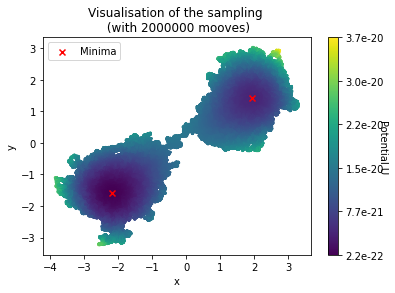

In [27]:
plt.scatter(x_list, y_list, c = U_list, s=3)
plt.scatter([x_list[min_ind_1],x_list[min_ind_2]], [y_list[min_ind_1],y_list[min_ind_2]], c = 'red', marker='x',label='Minima')

plt.xlabel('x')
plt.ylabel('y')
t = 'Visualisation of the sampling \n (with ' + str(Nbr_MC) + ' mooves)'
plt.title(t)
plt.legend()

cbar = plt.colorbar()

U_ticks = np.linspace(min(U_list), max(U_list), 6)
U_ticks = [str(U_ticks[i])[0:3] + str(U_ticks[i])[-4:] for i in range(len(U_ticks))]
cbar.ax.set_yticklabels(U_ticks)

cbar.set_label('Potential U', rotation=270)

print('Minimum 1 at: (', x_list[min_ind_1],y_list[min_ind_1], ') with U = ', U_min_1)
print()
print('Minimum 2 at: (', x_list[min_ind_2],y_list[min_ind_2], ') with U = ', U_min_2)

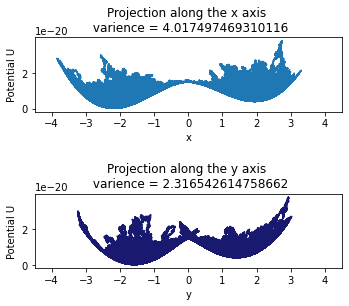

In [29]:
plt.subplot(211)
plt.plot(x_list, U_list)
t = 'Projection along the x axis \n varience = ' + str(sigma[0,0])
plt.title(t)
plt.xlim(-4.5, 4.5)
plt.xlabel('x')
plt.ylabel('Potential U')

plt.subplot(212)
plt.plot(y_list, U_list, c = 'midnightblue')
t = 'Projection along the y axis \n varience = ' + str(sigma[1,1])
plt.title(t)
plt.xlim(-4.5, 4.5)
plt.xlabel('y')
plt.ylabel('Potential U')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.show()

In [9]:
np.savez('save.npz', x_list, y_list, U_list)

## Task III: Sampling

Free energy :
$$\Delta G(x,y) = -k_{b}T ln(P(x,y))$$
$$ = (U2-U1) = \Delta U$$

With :
    $$ln(P) = - \frac{(U2-U1)}{k_{b}T}$$

In [10]:
lnP_list = [0]* Nbr_MC
for i in trange (1, Nbr_MC):
    U_1 = Potential_energy( x_list[i-1], y_list[i-1])
    U_2 = Potential_energy( x_list[i], y_list[i])
    lnP = abs((U_2 - U_1))
    lnP_list[i-1] = lnP

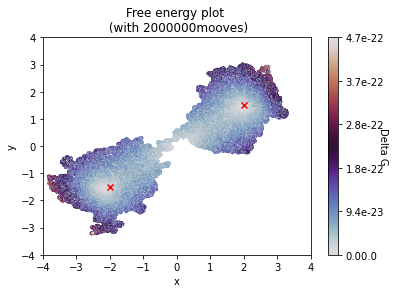

In [28]:
plt.scatter(x_list[1:], y_list[1:], c = lnP_list[:],cmap=plt.get_cmap('twilight'), s=3)
plt.scatter([2,-2], [1.5,-1.5], c = 'red', marker='x',label='Minima')

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-4,4)
plt.ylim(-4,4)

t = 'Free energy plot \n (with ' + str(Nbr_MC) + 'mooves)'
plt.title(t)

cbar = plt.colorbar(cm.ScalarMappable( cmap='twilight'))

lnP_ticks = np.linspace(min(lnP_list), max(lnP_list), 6)
lnP_ticks = [str(lnP_ticks[i])[0:3] + str(lnP_ticks[i])[-4:] for i in range(len(lnP_ticks))]
cbar.ax.set_yticklabels(lnP_ticks)

cbar.set_label('Delta G', rotation=270)

The lighter areas are ones with the lowest free energy and correspondingly with the smallest potential gradient. We can see that the free energy is minimised around the area of minimum potential but also along the conecting pathay between them.

## Task IV: PCA

**Means**

In [12]:
mean_x = np.mean(x_list)
mean_y = np.mean(y_list)

**Variances**

In [13]:
var_x = np.var(x_list)
var_y = np.var(y_list)

**Covariances and matrix $\sigma_{ij}$**

$\sigma_{ij} = 
\begin{pmatrix}
var(x) & cov(x,y)\\
cov(y,x) & var(y)
\end{pmatrix}$

In [14]:
sigma = np.cov(x_list, y_list)
print('𝜎_ij =  \n',sigma)

𝜎_ij =  
 [[4.01749747 2.81880472]
 [2.81880472 2.31654261]]


**Eigenvalues $\lambda_{k}$ and eigenvectors $\vec{e}_{\lambda k}$**

In [15]:
eig_values, eig_vectors = np.linalg.eig(sigma)

eig_vec_1 = eig_vectors[:,0]
eig_val_1 = eig_values[0]
eig_vec_2 = eig_vectors[:,1]
eig_val_2 = eig_values[1]

print('Lambda1 = ', eig_val_1, 'with eigenvector e1: ', eig_vec_1)
print('Lambda2 = ', eig_val_2, 'with eigenvector e2: ',eig_vec_2)


Lambda1 =  6.1113318329016835 with eigenvector e1:  [0.80276223 0.59629925]
Lambda2 =  0.22270825116709414 with eigenvector e2:  [-0.59629925  0.80276223]


The eigenvectors match the data as expected, as we can see that our first vector has the same direction as the connecting axis between the two minimas and that our second vector is perpendicular to the first our as expected.

(-4.0, 4.0)

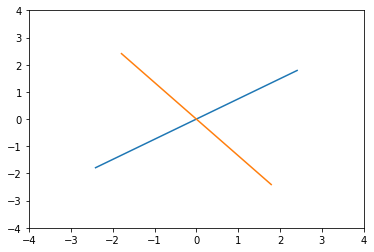

In [16]:
plt.plot([eig_vec_1[0]*(-3),eig_vec_1[0]*(3)], [eig_vec_1[1]*(-3),eig_vec_1[1]*(3)], label='Eingenvector 1')
plt.plot([eig_vec_2[0]*(-3),eig_vec_2[0]*(3)], [eig_vec_2[1]*(-3),eig_vec_2[1]*(3)], label='Eingenvector 2')
plt.xlim(-4,4)
plt.ylim(-4,4)

## Task V: Interpretation

**Angle $\theta$ between the eigenvector $\vec{e}_{λ1}$**

In [17]:
Theta = np.arctan(eig_vec_1[0]/eig_vec_1[1])
print('Theta ~', str(round(Theta/np.pi, 3)),'𝜋')

Theta ~ 0.297 𝜋


The angle $\theta$ found is close to $\frac{\pi}{3}$, which seems correct compared to the plot of the potential displayed in Task II.

**Clockwise rotation matrix R**

$R (\theta) = 
\begin{pmatrix}
Cos(\theta) & Sin(\theta)\\
-Sin(\theta) & Cos(\theta)
\end{pmatrix}$

$R \begin{pmatrix} x \\ y \end{pmatrix} = \begin{pmatrix} x' \\ y' \end{pmatrix}$

For $x'$ and $y'$ being the data in the rotated frame.

In [18]:
R = np.array([[np.cos(Theta), np.sin(Theta)],[- np.sin(Theta), np.cos(Theta)]])

**Calculate the data in the new frame**

In [19]:
x_rot_list = [R[0,0]*x_list[i] + R[0,1]*y_list[i] for i in trange(len(x_list))]
y_rot_list = [R[1,0]*x_list[i] + R[1,1]*y_list[i] for i in trange(len(x_list))]

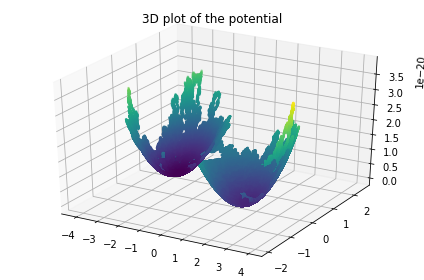

In [37]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.scatter(x_rot_list, y_rot_list, U_list, c=U_list, marker='o', s=2)

plt.title('3D plot of the potential')
#U_ticks = np.linspace(min(U_list), max(U_list), 6)
#U_ticks = [str(U_ticks[i])[0:3] + str(U_ticks[i])[-4:] for i in range(len(U_ticks))]

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(U_ticks)

#cbar.ax.set_yticklabels(U_ticks)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

In [35]:
sigma_new = np.cov(x_rot_list, y_rot_list)
print('Previous covarience matrix : \n 𝜎_ij =  \n',sigma)
v1 = sigma[0,0]+ sigma[1,1]
print(str(sigma[0,0]/v1*100)[0:2],'%')
print()
print('New covarience matrix : \n 𝜎_ij =  \n',sigma_new)
v2 = sigma_new[0,0]+ sigma_new[1,1]
print(str(sigma_new[0,0]/v2*100)[0:2],'%')

Previous covarience matrix : 
 𝜎_ij =  
 [[4.01749747 2.81880472]
 [2.81880472 2.31654261]]
63 %

New covarience matrix : 
 𝜎_ij =  
 [[ 5.62000353 -1.62844832]
 [-1.62844832  0.71403655]]
88 %


In [34]:
v1 = sigma[0,0]+ sigma[1,1]
v2 = sigma_new[0,0]+ sigma_new[1,1]
print(str(sigma[0,0]/v1*100)[0:2],'%', str(sigma_new[0,0]/v2*100)[0:2],'%')

63. % 88. %


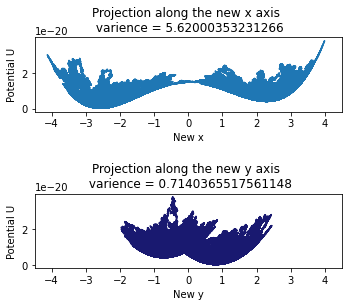

In [36]:
plt.subplot(211)
plt.plot(x_rot_list, U_list)
t = 'Projection along the new x axis \n varience = ' + str(sigma_new[0,0])
plt.title(t)
plt.xlim(-4.5, 4.5)
plt.xlabel('New x')
plt.ylabel('Potential U')

plt.subplot(212)
plt.plot(y_rot_list, U_list, c = 'midnightblue')
t = 'Projection along the new y axis \n varience = ' + str(sigma_new[1,1])
plt.title(t)
plt.xlim(-4.5, 4.5)
plt.xlabel('New y')
plt.ylabel('Potential U')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.show()

From the covarience matrix and from the above plot of the data along our new x and y axis we can clearly see that most of the varience is not contained in the first componant x (88% of the varience in contrast to 63% previously).

* "the histogram of Task III" is it not a plot that we are expecting? 
* $\Delta G$ equivalent to U ???
* add comments on the percentages